# expiMap

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 05.01.2023
- **Date of Last Modification:** 22.02.2023

- The expiMap source code is available at https://github.com/theislab/scarches.
- The corresponding preprint is "Lotfollahi, M. et al. Biologically informed deep learning to infer gene program activity in single cells. bioRxiv 2022.02.05.479217 (2022) doi:10.1101/2022.02.05.479217".
- The workflow of this notebook follows the tutorial from https://scarches.readthedocs.io/en/latest/expimap_surgery_pipeline_basic.html.
- We use a modified version of the autotalker gene program mask with only target genes as the gene program mask for expimap. The reasons are that it is relevant for cell communication, to improve comparability and since the expiMap method did not work well on this dataset with the reactome gene program used in the above cited tutorial.
- The authors use raw counts as input to expiMap. Therefore, we also use raw counts (stored in adata.X).

## 1. Setup

### 1.1 Import Libraries

In [1]:
import sys
sys.path.append("../../../autotalker")

In [14]:
import os
import time
from datetime import datetime

import gdown
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scarches as sca
import squidpy as sq
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Define Parameters

In [3]:
model_name = "expimap"
latent_key = f"{model_name}_latent"
leiden_resolution = 0.5 # used for Leiden clustering of latent space
random_seed = 0 # used for Leiden clustering

### 1.3 Run Notebook Setup

In [4]:
sc.set_figure_params(figsize=(6, 6))

In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [6]:
data_folder_path = "../../datasets/srt_data/gold/"
figure_folder_path = f"../../figures"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(gp_data_folder_path, exist_ok=True)

## 2. expiMap Model

### 2.1 Prepare Gene Program Mask

In [7]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=False,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

In [8]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=False,
    file_path=omnipath_lr_interactions_file_path)

In [9]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [10]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [11]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset", #None,
    combine_overlap_gps=True, #True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

### 2.2 Define Training Function

In [15]:
def train_expimap_models(dataset,
                         cell_type_key,
                         n_runs=10,
                         n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20]):
    
    # Configure figure folder path
    dataset_figure_folder_path = f"{figure_folder_path}/{dataset}/method_benchmarking/expimap/{current_timestamp}"
    os.makedirs(dataset_figure_folder_path, exist_ok=True)
    
    # Create original adata to store results from training runs
    adata_original = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
    
    model_seeds = list(range(10))
    for run_number, n_neighbors in zip(np.arange(1, n_runs+1), n_neighbor_list):
        # n_neighbors is here only used for the latent neighbor graph construction used for
        # UMAP generation and clustering as expiMap is not a spatial method
        
        # Load data
        adata = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
        
        # Store raw counts in optimized format in adata.X
        adata.layers["counts"] = adata.layers["counts"].tocsr()
        adata.X = adata.layers["counts"]
        
        adata.obs["batch"] == "batch1"  
        
        # Add the gene program dictionary as binary masks to the adata for model training
        # Use only target genes from the Autotalker gene program mask
        add_gps_from_gp_dict_to_adata(
            gp_dict=combined_new_gp_dict,
            adata=adata,
            genes_uppercase=True,
            gp_targets_mask_key="I",
            gp_sources_mask_key="_",
            gp_names_key="terms",
            min_genes_per_gp=1,
            min_source_genes_per_gp=0,
            min_target_genes_per_gp=0,
            max_genes_per_gp=None,
            max_source_genes_per_gp=None,
            max_target_genes_per_gp=None)

        # Determine dimensionality of hidden encoder
        n_hidden_encoder = len(adata.uns["terms"])
        
        start_time = time.time()
        
        # Initialize model
        intr_cvae = sca.models.EXPIMAP(adata=adata,
                                       condition_key="batch",
                                       hidden_layer_sizes=[256, 256, 256],
                                       recon_loss="nb")

        # Train model
        early_stopping_kwargs = {
            "early_stopping_metric": "val_unweighted_loss",
            "threshold": 0,
            "patience": 50,
            "reduce_lr": True,
            "lr_patience": 13,
            "lr_factor": 0.1}
        intr_cvae.train(
            n_epochs=400,
            alpha_epoch_anneal=100,
            alpha=0.7,
            alpha_kl=0.5,
            weight_decay=0.,
            early_stopping_kwargs=early_stopping_kwargs,
            use_early_stopping=True,
            monitor_only_val=False,
            seed=model_seeds[run_number-1])

        # Store latent representation
        adata.obsm[latent_key] = intr_cvae.get_latent(mean=False, only_active=True)
        
        # Measure time for model training
        end_time = time.time()
        elapsed_time = end_time - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Duration of model training in run {run_number}: {int(hours)} hours, {int(minutes)} minutes and {int(seconds)} seconds.")
        adata_original.uns[f"{model_name}_model_training_duration_run{run_number}"] = (
            elapsed_time)

        # Use expiMap latent space for UMAP generation
        sc.pp.neighbors(adata,
                        use_rep=latent_key,
                        n_neighbors=n_neighbors)
        sc.tl.umap(adata)
        fig = sc.pl.umap(adata,
                         color=[cell_type_key],
                         title="Latent Space with Cell Types: expiMap",
                         return_fig=True)
        fig.savefig(f"{dataset_figure_folder_path}/latent_{model_name}"
                    f"_cell_types_run{run_number}.png",
                    bbox_inches="tight")

        # Compute latent Leiden clustering
        sc.tl.leiden(adata=adata,
                     resolution=leiden_resolution,
                     random_state=random_seed,
                     key_added=f"latent_{model_name}_leiden_{str(leiden_resolution)}")

        # Create subplot of latent Leiden cluster annotations in physical and latent space
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
        title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: expiMap")
        sc.pl.umap(adata=adata,
                   color=[f"latent_{model_name}_leiden_{str(leiden_resolution)}"],
                   title=f"Latent Space with Leiden Clusters",
                   ax=axs[0],
                   show=False)
        sq.pl.spatial_scatter(adata=adata,
                              color=[f"latent_{model_name}_leiden_{str(leiden_resolution)}"],
                              title=f"Physical Space with Leiden Clusters",
                              shape=None,
                              ax=axs[1])

        # Create and position shared legend
        handles, labels = axs[0].get_legend_handles_labels()
        lgd = fig.legend(handles, labels, bbox_to_anchor=(1.25, 0.9185))
        axs[0].get_legend().remove()
        axs[1].get_legend().remove()

        # Adjust, save and display plot
        plt.subplots_adjust(wspace=0, hspace=0.2)
        fig.savefig(f"{dataset_figure_folder_path}/latent_physical_comparison_"
                    f"{model_name}_run{run_number}.png",
                    bbox_extra_artists=(lgd, title),
                    bbox_inches="tight")
        plt.show()

        # Store latent representation
        adata_original.obsm[latent_key + f"_run{run_number}"] = adata.obsm[latent_key]

        # Store active gene programs
        active_gps_idx = intr_cvae.nonzero_terms()
        adata_original.uns[f"{model_name}_active_gp_names_run{run_number}"] = (
            adata.uns["terms"][active_gps_idx])

        # Store intermediate adata to disk
        adata_original.write(f"{data_folder_path}/{dataset}_{model_name}.h5ad")

    # Store final adata to disk
    adata_original.write(f"{data_folder_path}/{dataset}_{model_name}.h5ad")    

### 2.3 Train Models on Benchmarking Datasets


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 351 256 2
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 489
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  489 0 0 2 351
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |████----------------| 23.8%  - epoch_loss: 284.7051123047 - epoch_recon_loss: 268.1335075378 - epoch_kl_loss: 35.2587327957 - val_loss: 286.1334737142 - val_recon_loss: 269.7815933228 - val_kl_loss: 34.79123433433
ADJUSTED LR
 |█████---------------| 28.7%  - epoch_loss: 285.3553839111 - epoch_recon_loss: 268.5646157837 - epoch_kl_loss: 33.5815362358 - val_loss: 287.6763509115 - val_recon_loss: 271.2399978638 - val_kl_loss: 32.8727010091
ADJUSTED LR
 |██████--------------| 33.5%  - epoch_loss: 283.2056906128 - epoch_recon_loss: 266.4377555847 - epoch_kl_loss: 33.5358718300 - val_loss: 283.4606437683 - va

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


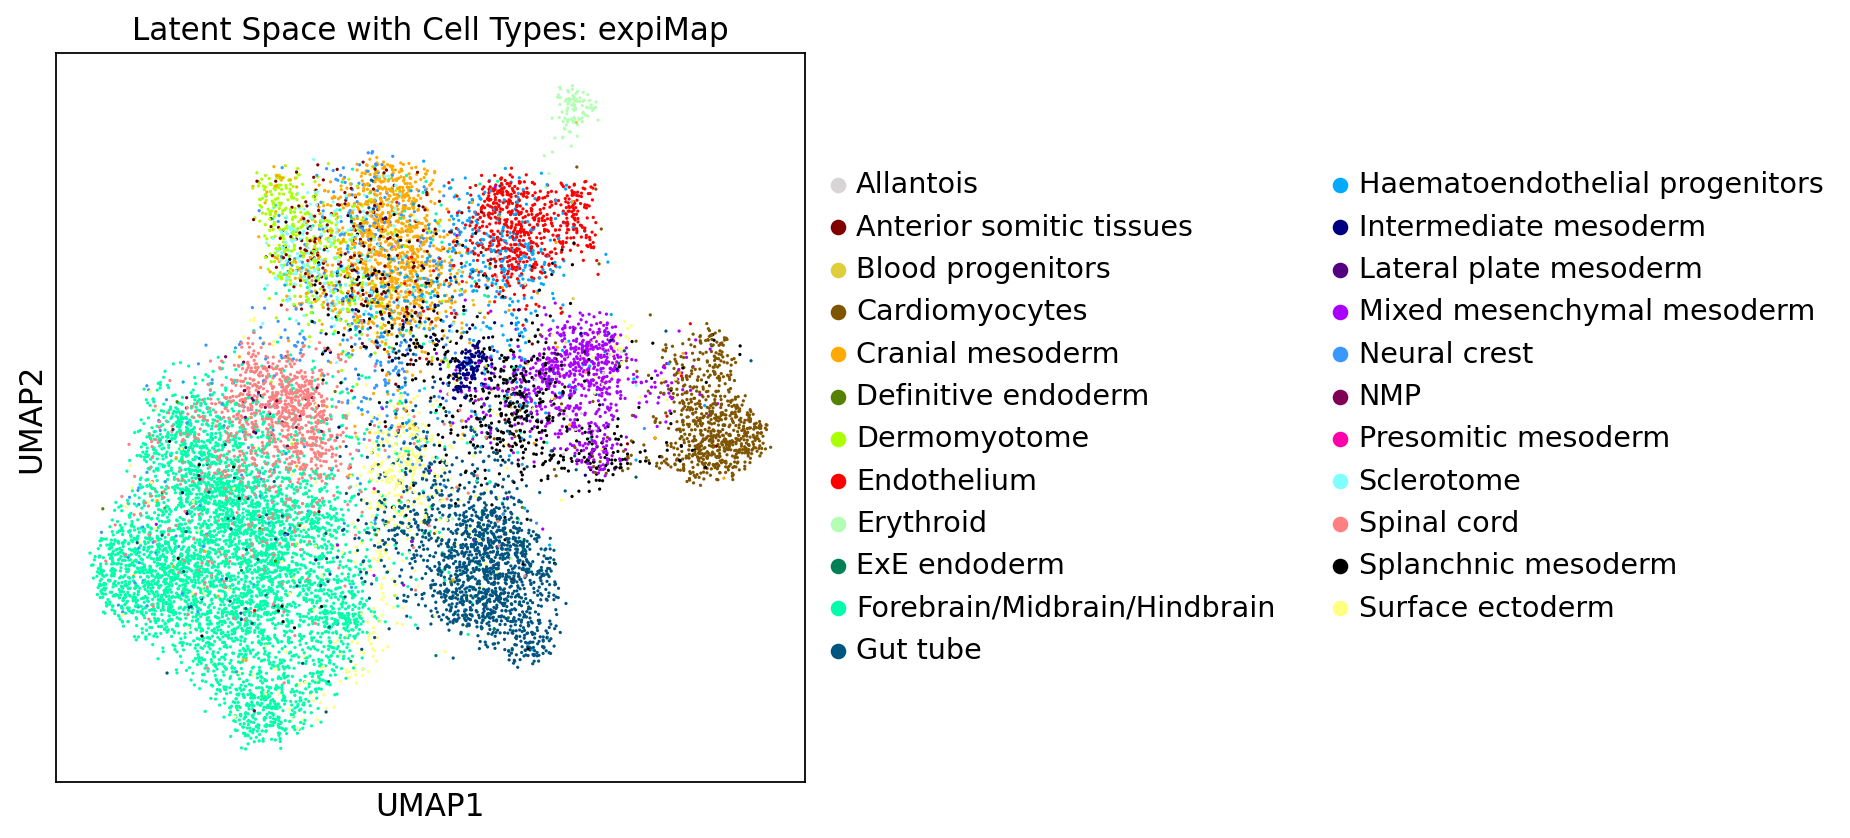

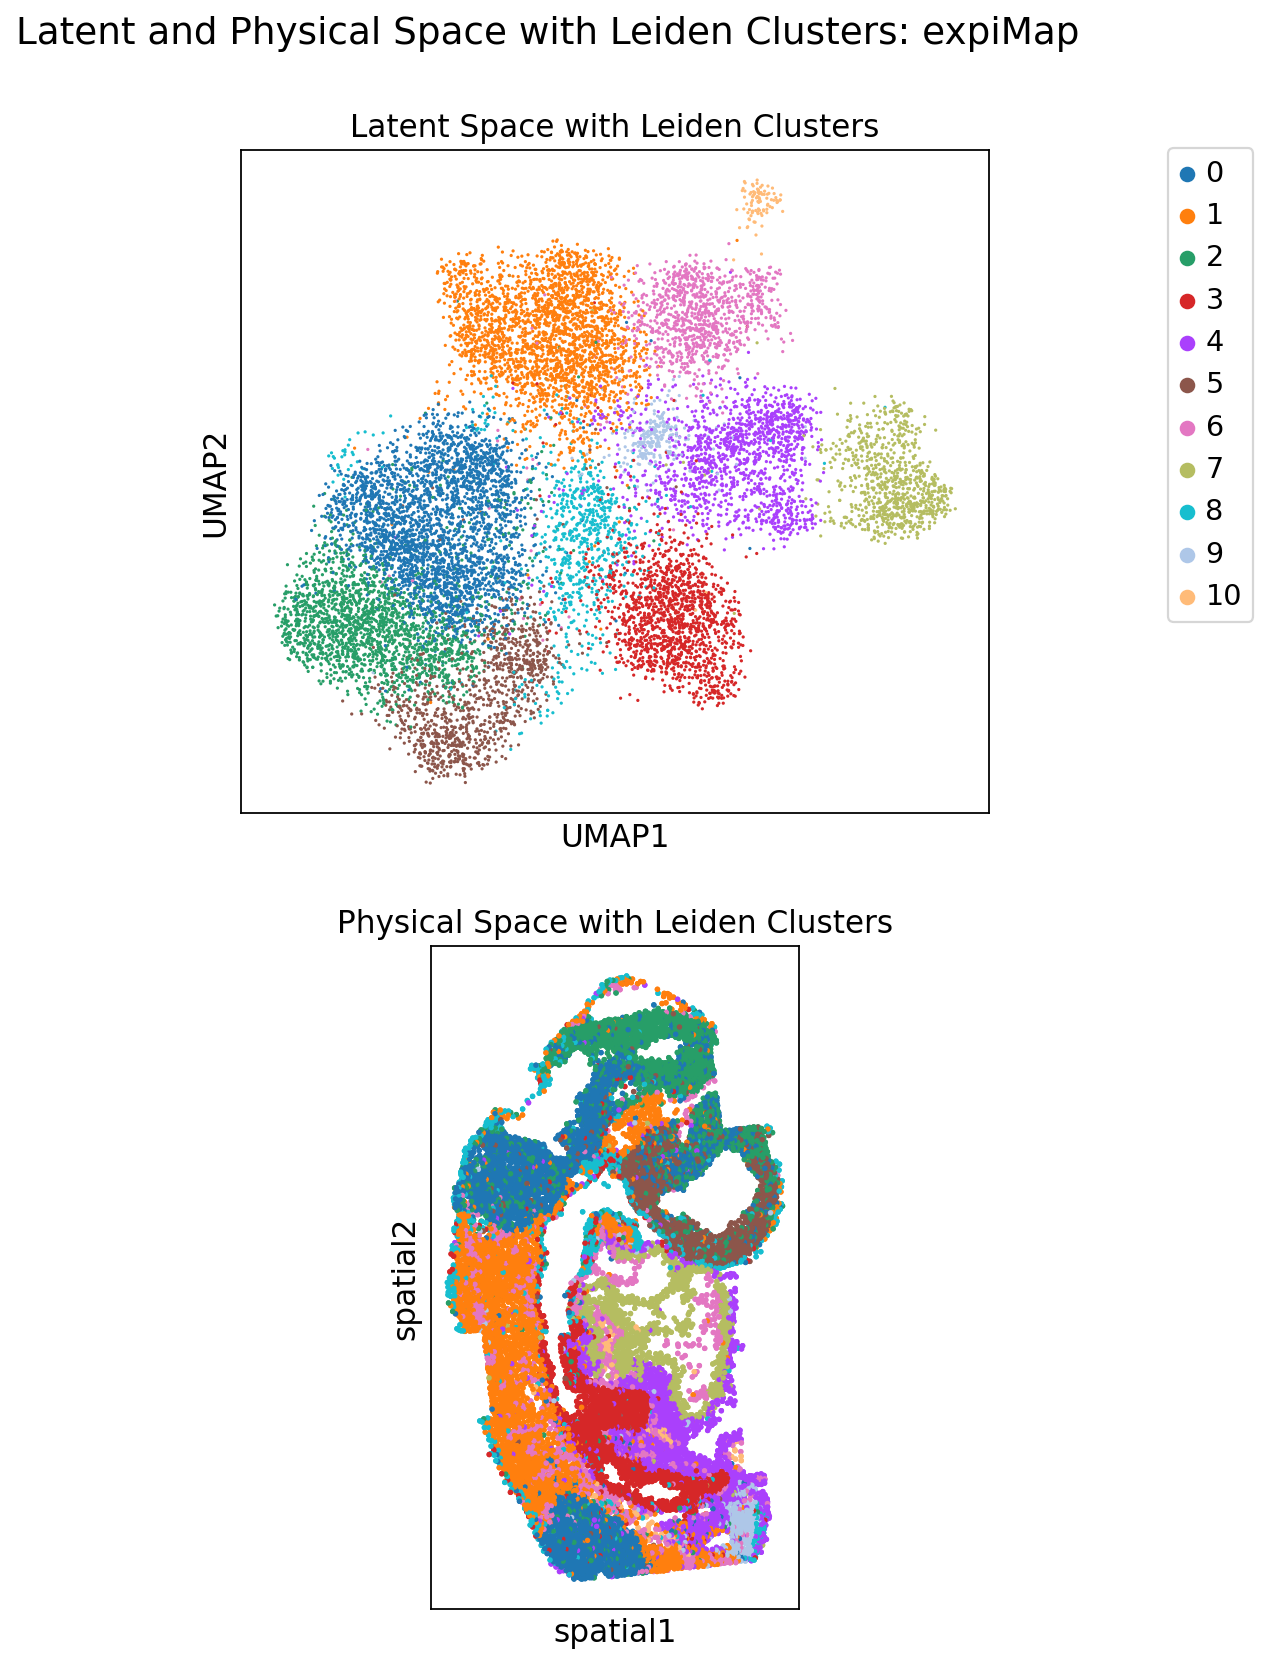


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 351 256 2
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 489
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  489 0 0 2 351
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |█████---------------| 28.7%  - epoch_loss: 284.1022424316 - epoch_recon_loss: 267.7322250366 - epoch_kl_loss: 32.7400329018 - val_loss: 288.5050735474 - val_recon_loss: 272.5777651469 - val_kl_loss: 31.85461632418
ADJUSTED LR
 |██████--------------| 34.0%  - epoch_loss: 283.4554827881 - epoch_recon_loss: 267.0052502441 - epoch_kl_loss: 32.9004651642 - val_loss: 282.7365697225 - val_recon_loss: 266.7421824137 - val_kl_loss: 31.9887685776
ADJUSTED LR
 |███████-------------| 39.2%  - epoch_loss: 283.3486224365 - epoch_recon_loss: 266.9204701233 - epoch_kl_loss: 32.8563080597 - val_loss: 285.8892415365 - va

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


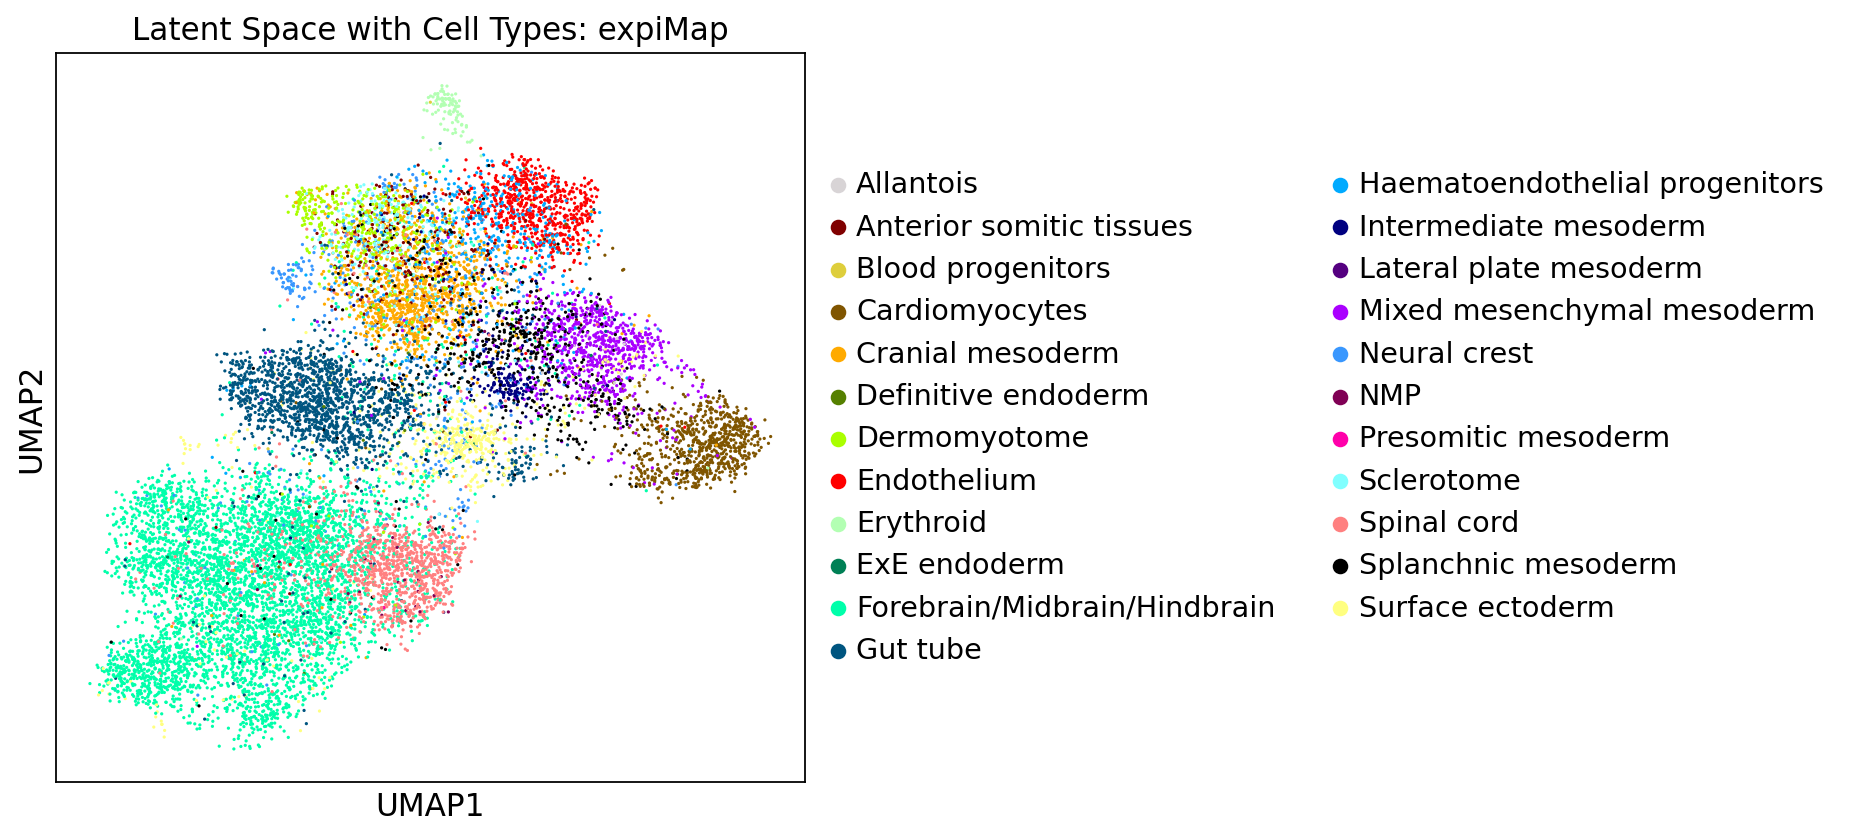

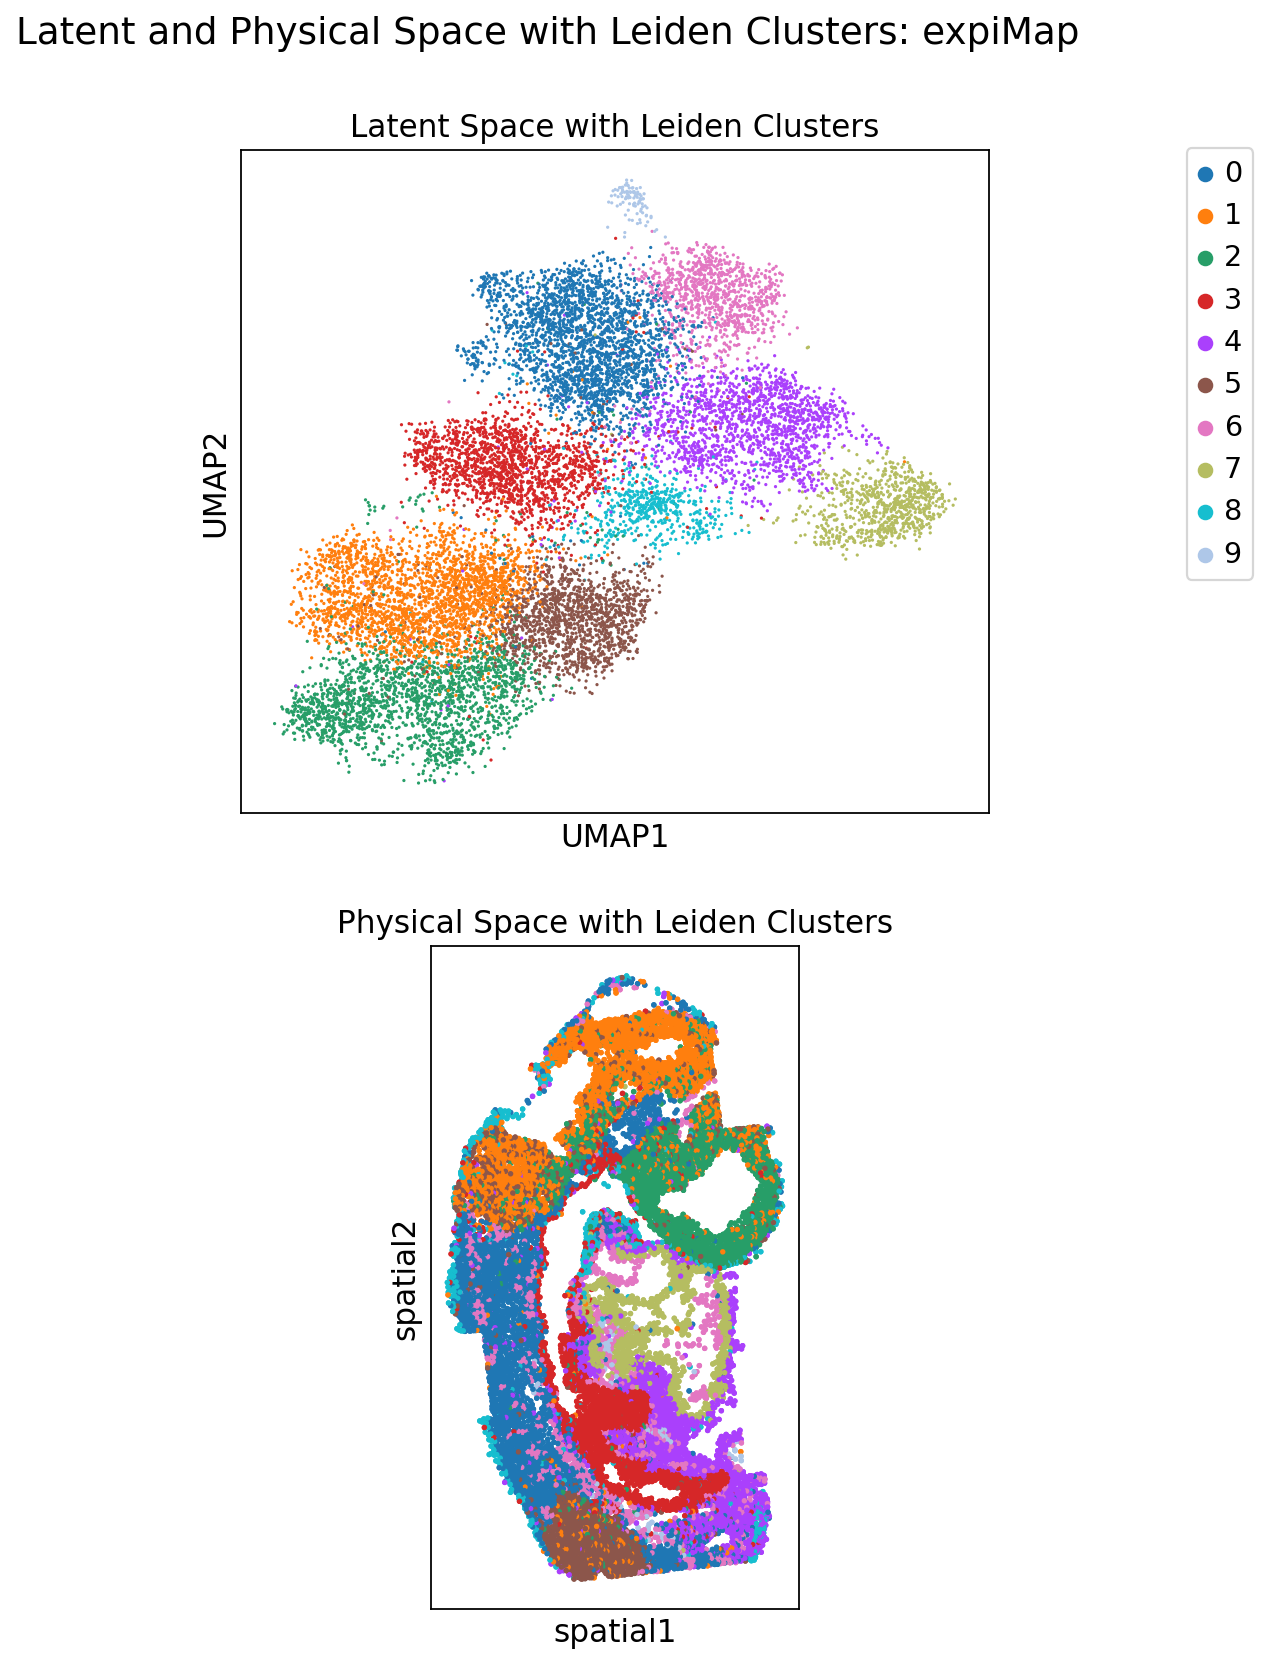


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 351 256 2
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 489
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  489 0 0 2 351
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |█-------------------| 6.5%  - epoch_loss: 277.7491809082 - epoch_recon_loss: 268.0340090942 - epoch_kl_loss: 77.7213815308 - val_loss: 270.8783315023 - val_recon_loss: 261.4087181091 - val_kl_loss: 75.756926218726

In [ ]:
train_expimap_models(dataset="seqfish_mouse_organogenesis_embryo2",
                     cell_type_key="celltype_mapped_refined")

In [ ]:
train_expimap_models(dataset="vizgen_merfish_mouse_liver",
                     cell_type_key="Cell_Type")

In [ ]:
train_expimap_models(dataset="starmap_plus_mouse_cns",
                     cell_type_key="Main_molecular_cell_type")

In [ ]:
train_expimap_models(dataset="nanostring_cosmx_human_nsclc",
                     cell_type_key="cell_type")